In [1]:
import os
import sys

#### VP Tree

sys.path.append(os.getcwd() + "/vp_trees_cpp/vp_trees_cpp")

from vp_tree import FS_metric
from vp_tree import tree_container

from utilities.load_trajectory import load_trajectory
from utilities.utilities.fubini_study import FS_metric

import time

## load trajectory data from file
import pickle

## diffusion maps
from diffusion_maps import run_diffusion_map
from diffusion_maps import run_diffusion_map_dense

## numerical
import numpy as np
from numpy import linalg as la
# from numpy.random import normal
import random
from scipy import sparse
# from scipy.sparse.linalg import eigsh
# from scipy.sparse.linalg import eigs

from sklearn.cluster import k_means
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

from hmmlearn import hmm

## plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
# from mpl_toolkits.mplot3d import axes3d
# import matplotlib.cm as cm

import collections
from scipy.stats import rankdata

## Style for plots
plt.style.use("ggplot")

# 3D plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from bisect import bisect

## Supporting functions

In [2]:
def contour_plot(Mat):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(abs(Mat), interpolation='nearest')
    fig.colorbar(cax)
    plt.show()

In [3]:
def make_markov_model(labels,n_clusters):
    T = np.zeros((n_clusters,n_clusters))
    for i in range(len(labels)-1):
        j = i + 1
        T[labels[i],labels[j]] += 1
    row_norm = np.squeeze(np.asarray(T.sum(axis = 1)))
    row_norm = np.power(row_norm,-1)
    row_norm = np.nan_to_num(row_norm)
    return (T.T*row_norm).T

In [4]:
## Count sparse elements greater than small eps.
def count_greater_than_eps(M,eps = 0.):
    count = 0
    for el in np.nditer(M):
        if abs(el) > eps:
            count += 1
    return count

In [5]:
def next_state(state,T_cum):
    r = np.random.uniform()
    return bisect(np.asarray(T_cum)[state], r)

def run_markov_chain(start_cluster, T, steps = 1000):
    '''
    Run Markov chain for a single trajectory.
    '''

    T_cum = np.matrix(np.zeros_like(T))

    for i in range(T.shape[1]):
        s = 0
        for j in range(T.shape[0]):
            s += T[i,j]
            T_cum[i,j] = s
    
    current = start_cluster
    outs = []
    for i in range(steps):
        outs.append(current)
        current = next_state(current,T_cum)
    return np.asarray(outs)

In [6]:
def time_series_ave(series,time_series_ave_over = 30,indices_len = None):
    '''
    This function returns the time series where values have been averged over 
    time_series_ave_over timesteps. The resulting average is repeated 
    time_series_ave_over times so the time axis matches the origin series.
    '''
    
    if indices_len is None:
        indices_len = len(series)
    return np.concatenate([ 
            [np.average(series[time_series_ave_over*i:time_series_ave_over*(i+1)])]
                *time_series_ave_over 
                    for i in range((indices_len)/time_series_ave_over)])

In [7]:
def get_clusters(labels,n_clusters = 30):
    clusters = [[] for _ in range(n_clusters)]
    for point,cluster in enumerate(labels):
        clusters[cluster].append(point)
    return clusters

In [8]:
def cluster_stats(labels,expects_index = 0, n_clusters = 30):
    expects_sampled = [traj_expects[expects_index][i] for i in sample_indices]
    clusters = get_clusters(labels,n_clusters)
    
    cluster_averages = []
    cluster_std_devs = []
    for cluster in clusters:
        expect_in_cluster = [expects_sampled[i] for i in cluster]
        cluster_averages.append(np.average(expect_in_cluster))
        cluster_std_devs.append(np.std(expect_in_cluster))

    cluster_values =  [ (  [ave]*len(c), 
                            map(lambda z: expects_sampled[z] ,c),
                            [std]*len(c))
                                   for c,ave,std in 
                                       zip(clusters,cluster_averages,cluster_std_devs)
                          ]

    cluster_values = sorted(cluster_values,key= lambda z:z[0][0])
    cluster_sorted = np.concatenate([v[0] for v in cluster_values])
    inside_cluster_sorted = np.concatenate([v[1] for v in cluster_values])
    cluster_std_devs_sorted = np.concatenate([v[2] for v in cluster_values])
    
    return clusters,expects_sampled,cluster_sorted,inside_cluster_sorted,cluster_std_devs_sorted

In [9]:
def summarizing_plots(n_clusters,labels,clusters,specific_points = False, bins = 100):
    plt.hist([len(c) for c in clusters], bins = bins);

    ## Transition matrix
    T = make_markov_model(labels,n_clusters)
    contour_plot(T);

    for i in range(3):
        clusters,expects_sampled,cluster_sorted,inside_cluster_sorted,cluster_std_devs_sorted = cluster_stats(labels,expects_index = i, n_clusters = n_clusters)
        plt.errorbar(range(len(cluster_sorted)),cluster_sorted, yerr=cluster_std_devs_sorted);
        l1 = plt.plot(sorted(expects_sampled));
        plt.setp(l1, linewidth=3);
        plt.show()
        
        if specific_points:
            plt.plot(inside_cluster_sorted);
            l1 = plt.plot(sorted(expects_sampled));
            plt.setp(l1, linewidth=3);
            plt.show()

In [10]:
def get_point_in_which_cluster(clusters):
    '''
    Dictionary mapping each point to its cluster
    '''
    point_in_which_cluster = {}
    for clust_index,cluster in enumerate(clusters):
        for point in cluster:
            point_in_which_cluster[point] = clust_index
    return point_in_which_cluster

In [11]:
def get_obs_sample_points(sample_indices):
    '''
    Observed quantities at sampled points
    '''
    obs_sample_points = {}
    for l in obs_indices:
        obs_sample_points[l] = np.asarray([ traj_expects[l][j] for j in sample_indices])
    return obs_sample_points

In [12]:
def get_expect_in_clusters(clusters, n_clusters, obs_sample_points):
    '''
    Get the average expectation value in each cluster.
    '''
    expect_in_clusters = {}
    for l in obs_indices:
        expect_in_clusters[l] = [0. for _ in range(n_clusters)]
        for clust_index,cluster in enumerate(clusters):
            for point in cluster:
                expect_in_clusters[l][clust_index] += obs_sample_points[l][point]
            if len(cluster) != 0:
                expect_in_clusters[l][clust_index] /= float(len(cluster))
            else:
                expect_in_clusters[l][clust_index] = None
    return expect_in_clusters

In [13]:
def get_reduced_model_time_series(expect_in_clusters,indices,point_in_which_cluster):
    '''
    Return the average expectation value over clusters
    as a time series of the true trajectory
    '''
    return [[expect_in_clusters[l][point_in_which_cluster[point]] 
                for point in range(len(indices))] for l in obs_indices]

In [14]:
def plot_original_versus_reduced_timeseries(obs_sample_points, reduced_model_time_series):
    for l in obs_indices:
        f, axarr = plt.subplots(3, 2,figsize=(30,20))
        axarr[0, 0].plot(reduced_model_time_series[l])
        axarr[0, 0].set_title("Reduced model, observable #" + str(l))    
        axarr[1, 0].plot(time_series_ave(reduced_model_time_series[l],10))
        axarr[1, 0].set_title("Reduced model, observable #" + str(l)+ ", averaged over 10 timesteps")
        axarr[2, 0].plot(time_series_ave(reduced_model_time_series[l],30))
        axarr[2, 0].set_title("Reduced model, observable #" + str(l)+ ", averaged over 30 timesteps")
        axarr[0, 1].plot(obs_sample_points[l])
        axarr[0, 1].set_title("Original model, observable #" + str(l))
        axarr[1, 1].plot(time_series_ave(obs_sample_points[l],10))
        axarr[1, 1].set_title("Original model, observable #" + str(l)+ ", averaged over 10 timesteps")
        axarr[2, 1].plot(time_series_ave(obs_sample_points[l],30))
        axarr[2, 1].set_title("Original model, observable #" + str(l)+ ", averaged over 30 timesteps")
        plt.show()

In [15]:
def get_obs_generated(T_matrix, ## Transition matrix used
                      expect_in_clusters,
                      start_cluster = 0, ## index of starting cluster
                      steps = 10000,
                      n_clusters = 10,
                     ):

    steps = run_markov_chain(start_cluster,T_matrix, steps = steps)
    obs_generated = [[expect_in_clusters[l][cluster] for cluster in steps ] for l in obs_indices]
    return obs_generated

In [16]:
def plot_original_versus_generated_timeseries(obs_generated,obs_sample_points):
    f, axarr = plt.subplots(3, 2,figsize=(30,20))
    for l in obs_indices:
        axarr[l, 0].plot(time_series_ave(obs_generated[l],5))  
        axarr[l, 1].plot(time_series_ave(obs_sample_points[l],5))
    plt.show()

In [17]:
def get_hmm_hidden_states(X,n_clusters = 30, return_model = False,n_iter=100, covariance_type = 'full'):
    hmm_model = hmm.GaussianHMM(n_components=n_clusters, covariance_type=covariance_type, n_iter = n_iter)
    hmm_model.fit(X)
    print "converged", hmm_model.monitor_.converged
    hidden_states = hmm_model.predict(X)
    if not return_model:
        return hidden_states
    else:
        return hidden_states, hmm_model

##  Functions for testing transition times

In [18]:
def count_transitions(timeseries, high, low):
    current_state = 0
    num_trans = 0
    for val in timeseries:
        if current_state == 0 and val > high:
            current_state = 1
            num_trans += 1
        if current_state == 1 and val < low:
            current_state = 0
            num_trans += 1
    return num_trans

In [19]:
def trans_2_clusters(Y):
    hmm_photon_number = hmm.GaussianHMM(n_components=2, covariance_type='full', n_iter = 100)
    hmm_photon_number.fit(Y)
    print "converged", hmm_photon_number.monitor_.converged
    hidden_photon_number_cluster = hmm_photon_number.predict(Y)
    return hidden_photon_number_cluster

In [20]:
def count_label_trans(series):
    current = series[0]
    count = 0
    for n in series[1:]:
        if current != n:
            current = n
            count += 1
    return count

In [21]:
def cluster_observable_series(obs_series, moving_ave = 50, method = 'k_means', plot = True):
    averaged_reduced_timeseries = time_series_ave(obs_series,moving_ave)
    Y = np.asarray([[i] for i in averaged_reduced_timeseries])
    
    if method == 'k_means':
        k_means_trans = k_means(Y,n_clusters = 2)[1]
        if plot:
            plt.title("clustered with k means")
            plt.plot(k_means_trans)
            plt.plot(Y)
        return count_label_trans(k_means_trans)
    elif method == 'hmm':
        hidden_photon_number_cluster = trans_2_clusters(Y)
        if plot:
            plt.plot(hidden_photon_number_cluster)
            plt.plot(Y)
            plt.title("clustered with hmm")
            plt.show()
        return count_label_trans(hidden_photon_number_cluster)
    else:
        raise ValueError('unknown method')

In [22]:
def transition_stats(timeseries,num_chunck = 20,moving_ave =10):
    obs_chuncks = np.array_split(timeseries,num_chunck)
    obs_sample_trans = [cluster_observable_series(chunk,moving_ave=moving_ave,plot = False)
                            for chunk in obs_chuncks]

    print "num transitions in each chunck",obs_sample_trans
    print "Expected steps before transition",np.average([len(chunck) for chunck in obs_chuncks]) / np.average(obs_sample_trans) 
    print "total transitions", sum(obs_sample_trans)
    print "Estimated relative error",np.std(obs_sample_trans) / (np.average(obs_sample_trans)* np.sqrt(num_chunck) )
    return obs_sample_trans

In [23]:
def train_for_hmm(X,n_clusters,covariance_type = 'full'):
    labels = get_hmm_hidden_states(X,n_clusters,return_model=False, n_iter=1000, covariance_type = covariance_type)
    clusters = get_clusters(labels,n_clusters)
    T = make_markov_model(labels,n_clusters)
    return (labels,clusters,T)

In [24]:
def train_for_agg_clustering(X,n_clusters):
    labels = get_cluster_labels(X,n_clusters)
    clusters = get_clusters(labels,n_clusters)
    T = make_markov_model(labels,n_clusters)
    return (labels,clusters,T)

In [25]:
def get_cluster_labels(X,n_clusters = 30):
    knn_graph = kneighbors_graph(X, 100, include_self=False)

    model = AgglomerativeClustering(linkage='ward',
                                    connectivity=knn_graph,
                                    n_clusters=n_clusters)

    model.fit(X)
    labels = model.labels_
    return labels

In [26]:
def models_on_fixed_chunk(X,
                          clusters,
                          steps,
                          sample_indices,
                          which_clusters = [30],
                          sampled_chunk = 1, 
                          training_scheme = 'agg_clustering',
                          covariance_type = 'full'
                         ):

    labels_d = {}
    clusters_d = {}
    T_d = {}
    timeseries = {}

    for n_clusters in which_clusters:
        if training_scheme == 'agg_clustering':
            (labels_d[sampled_chunk,n_clusters],
                 clusters_d[sampled_chunk,n_clusters],
                 T_d[sampled_chunk,n_clusters]) = train_for_agg_clustering(X,n_clusters)
        elif training_scheme == 'hmm':
            (labels_d[sampled_chunk,n_clusters],
                 clusters_d[sampled_chunk,n_clusters],
                 T_d[sampled_chunk,n_clusters]) = train_for_hmm(X,n_clusters,covariance_type = covariance_type)
        else:
            raise ValueError("unknown scheme for training.")
        labels = labels_d[sampled_chunk,n_clusters]
        clusters = clusters_d[sampled_chunk,n_clusters]
        T = T_d[sampled_chunk,n_clusters]

        point_in_which_cluster = get_point_in_which_cluster(clusters)
        obs_sample_points = get_obs_sample_points(sample_indices)
        expect_in_clusters = get_expect_in_clusters(clusters,n_clusters, obs_sample_points)
        obs_generated = get_obs_generated(T,expect_in_clusters,steps = steps) 

        timeseries[sampled_chunk,n_clusters] = obs_generated[0]
        print "completed n_clusters", n_clusters
    return labels_d,clusters_d,T_d,timeseries

## Load trajectory

In [27]:
## observables are: (a, j, jz, a*a, a.dag()*a, a*jp, jp, jx, jy)

Ntraj,duration,traj_data,traj_expects = load_trajectory("absorptive_bistable")
num_data_points = len(traj_data)

## Set up settings

In [28]:
num_sample_points = 10000 ## NA if using hand_picked indices
obs_indices = range(3)
sample_type = 'hand_picked'

num_chunck = 20
handpick_indices  = lambda: np.array_split(np.arange(num_data_points),num_chunck)[-5:][1]

## Sample Trajectory

In [29]:
if sample_type == 'uniform_time':
    downsample_rate = num_data_points / num_sample_points
    sample_indices = range(num_data_points)[::downsample_rate]
elif sample_type == 'uniform_random':
    sample_indices = random.sample(range(num_data_points),num_sample_points)
elif sample_type == 'first_n':
    sample_indices = range(num_sample_points)
elif sample_type == 'last_n':
    sample_indices = range(num_data_points - num_sample_points, num_data_points)
elif sample_type == 'hand_picked':
    sample_indices = handpick_indices()
else:
    raise ValueError("unknown sample_type")

## Run Diffusion Map

In [30]:
load_diff_coords = True ## Try to load file. If not found, run diffuion maps again
save_diff_coords = False ## Save diffuion maps data into file. Overwrite if it exists.
Regime = "absorptive_bistable" ## used for naming of file

In [31]:
points = np.asarray([traj_data[i] for i in sample_indices])

In [32]:
if load_diff_coords:
    try:
        pkl_file = open('diff_coords' + Regime +'.pkl', 'rb')
        vals,vecs = pickle.load(pkl_file)
        pkl_file.close()
    except IOError:
        print "diffusion coordinates file not found. Instead running diffuions maps (this may take a few mintues)."
        load_diff_coords = False
if not load_diff_coords: ## if we're not loading, 
    distance_matrix = FS_metric(points,points)
    vals,vecs = run_diffusion_map_dense(distance_matrix,eps=0.5, alpha = 0.5, 
                                    eig_lower_bound = 0, eig_upper_bound = 7)

In [33]:
if save_diff_coords:
    pkl_file = open('diff_coords' + Regime +'.pkl', 'wb')
    pickle.dump((vals,vecs),pkl_file)
    pkl_file.close()

## Plot diffusion map results

In [93]:
color_by_percentile = True
plot_2D = True
plot_3D = False

max_coord1 = 2  #5
max_coord2 = 4  #6

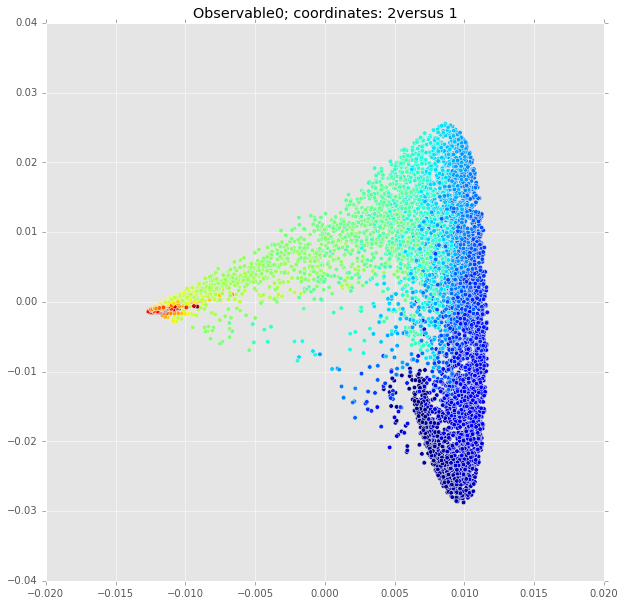

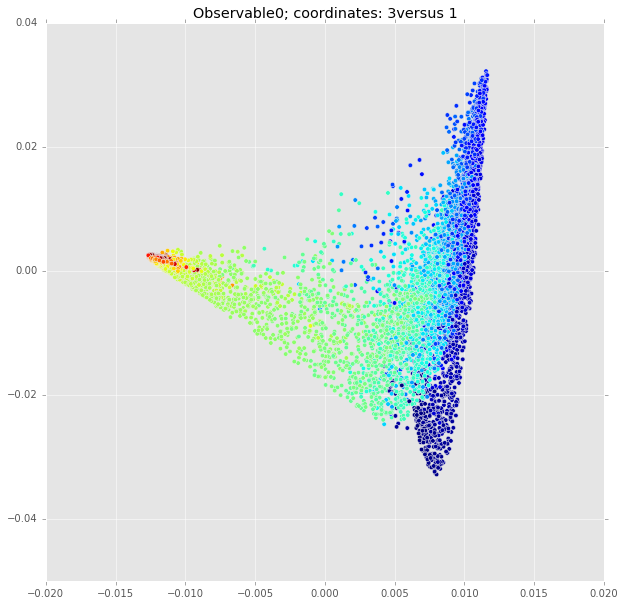

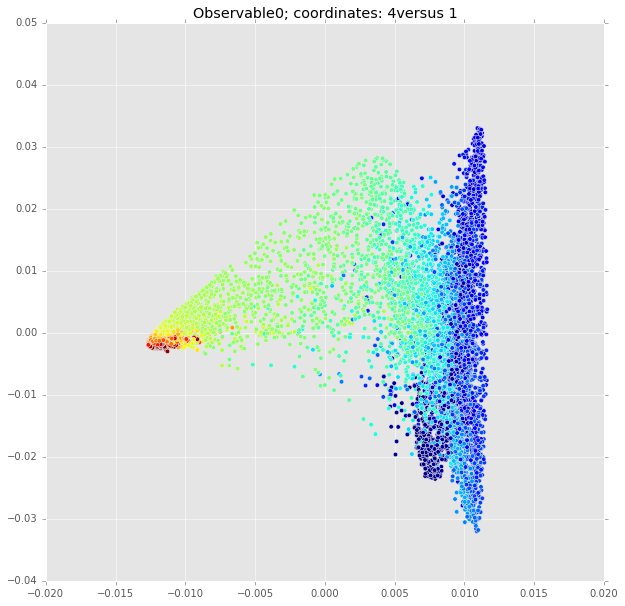

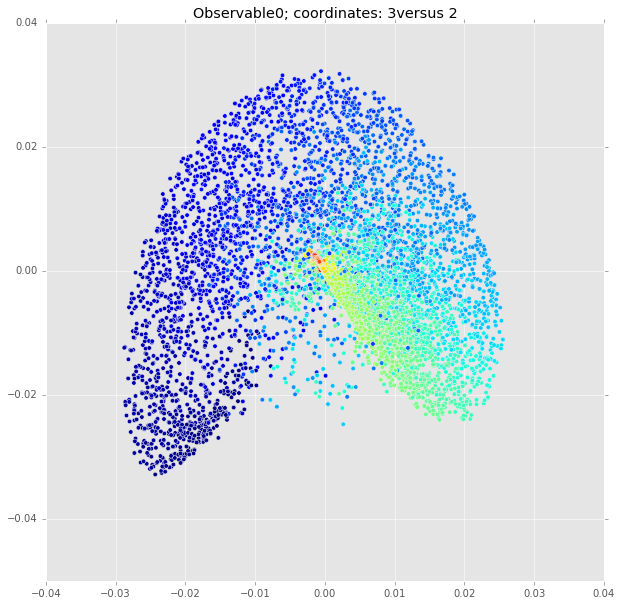

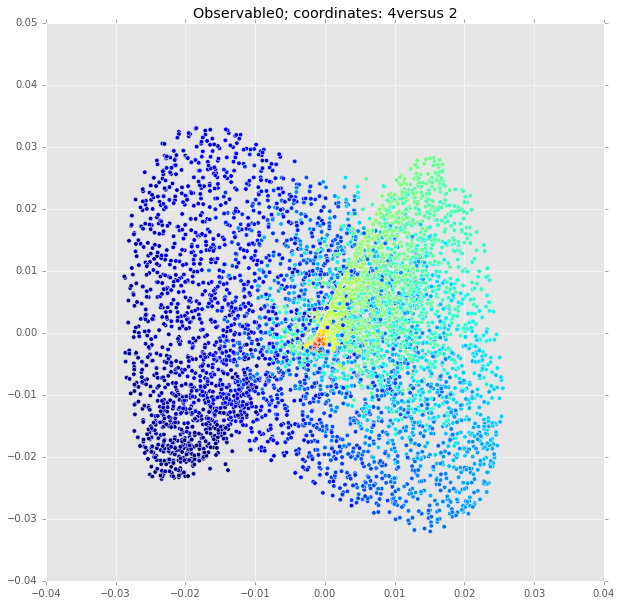

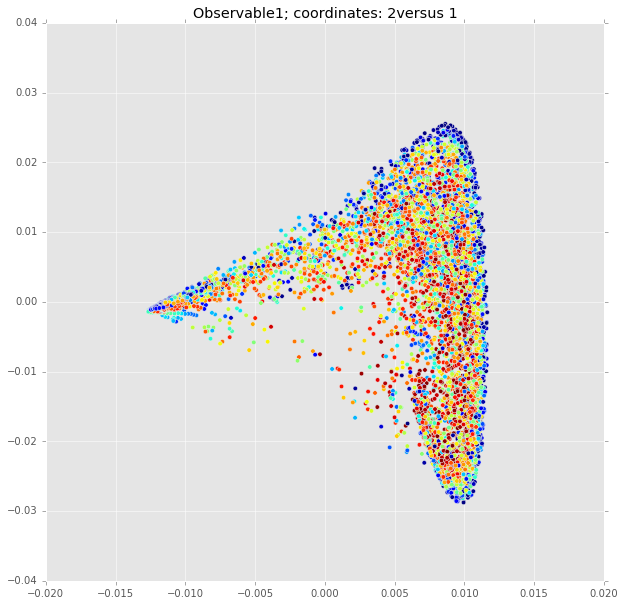

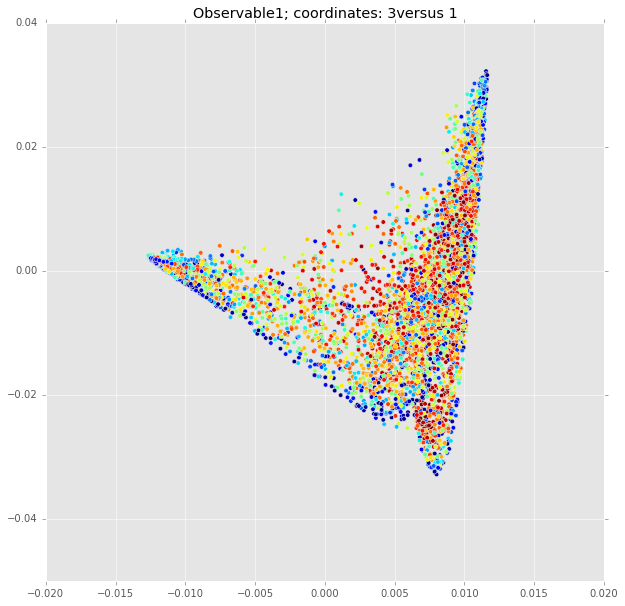

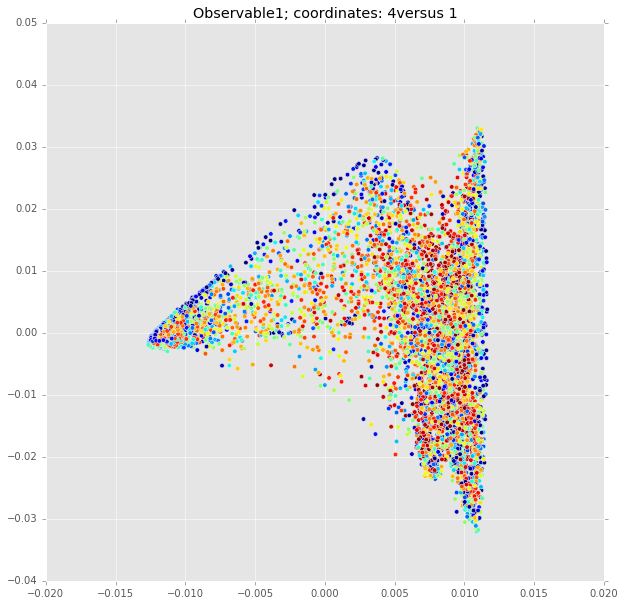

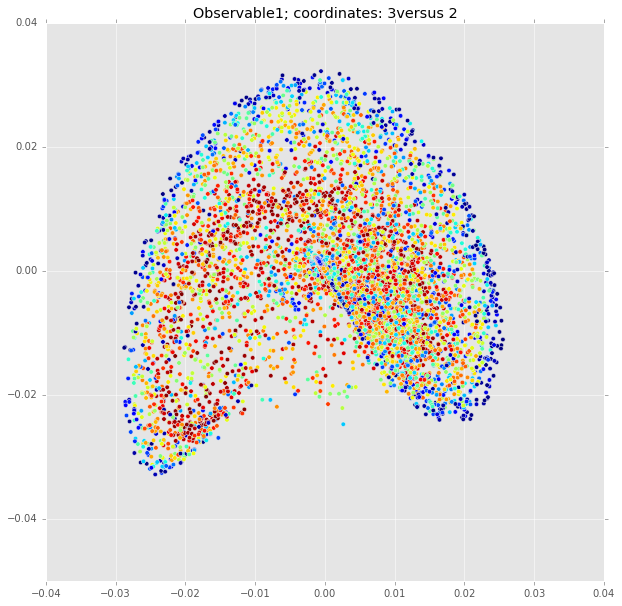

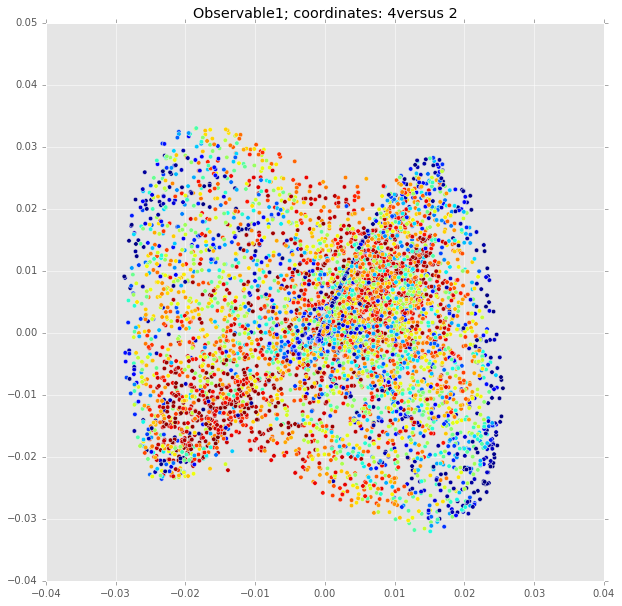

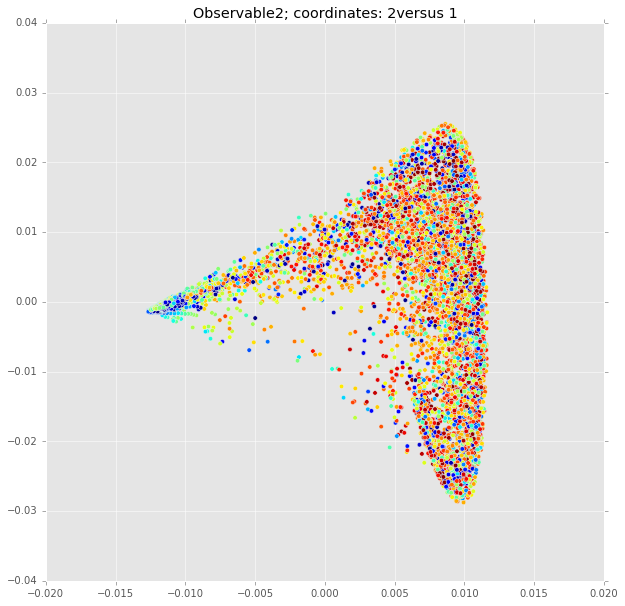

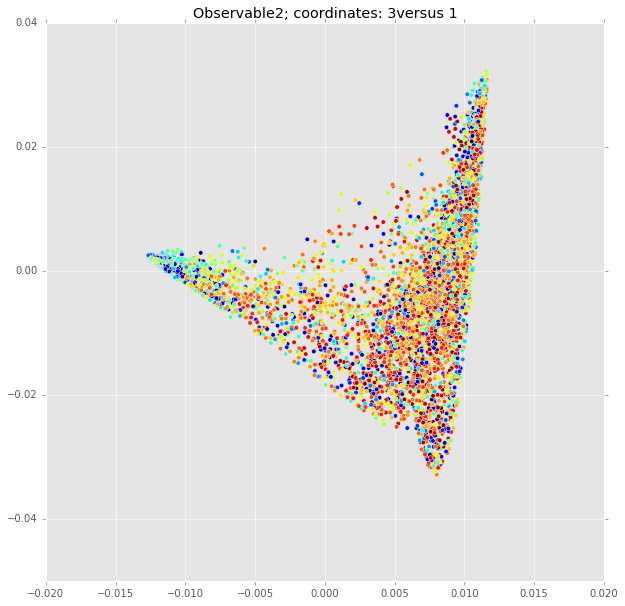

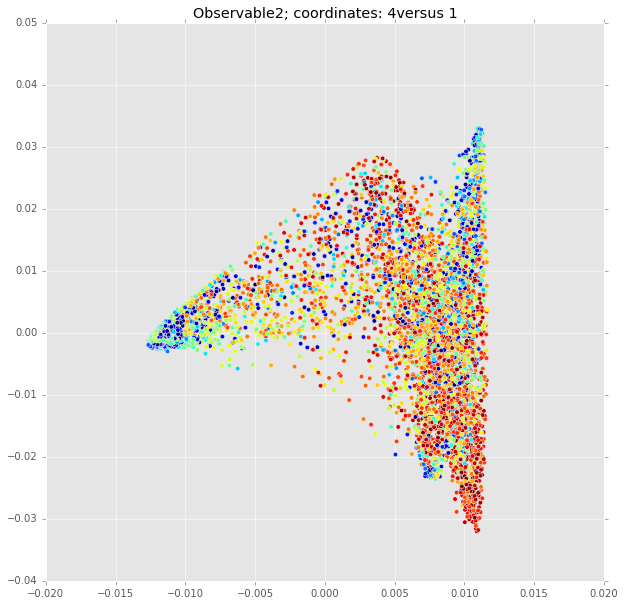

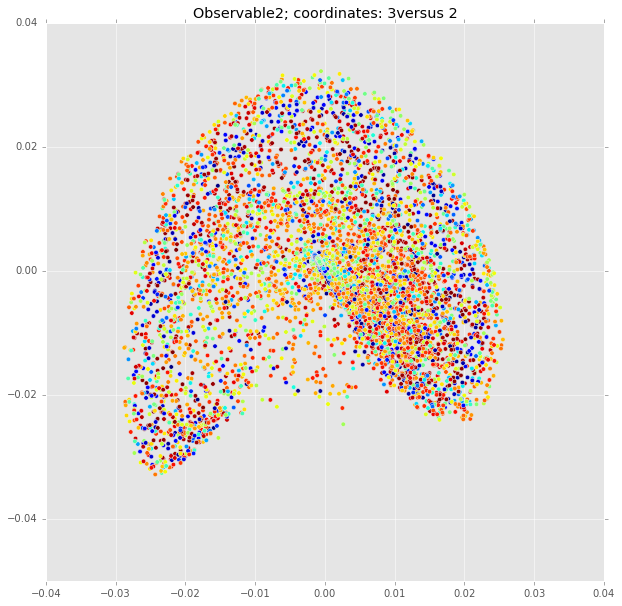

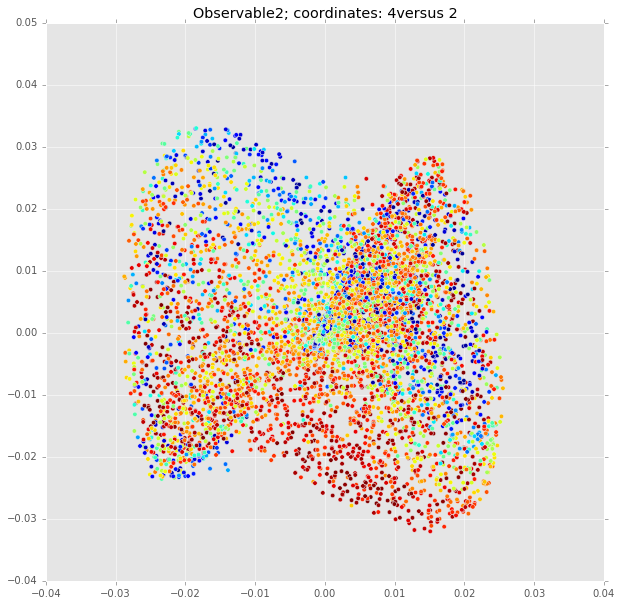

In [94]:
for l in obs_indices:
    obs_sample_points = np.asarray([ traj_expects[l][j] for j in sample_indices])
    if color_by_percentile:
        obs_sample_points = rankdata(obs_sample_points, "average") / num_sample_points
    if plot_2D:
        for k in range(1,max_coord1+1):
            for i in range(1+k,max_coord2+1):
                plt.figure(figsize= (10,10))
                plt.scatter(vecs[:,k],vecs[:,i], c = obs_sample_points)
                plt.title("Observable" + str(l) + "; coordinates: " + str(i) + "versus " + str(k) )  

    if plot_3D:
        fig = plt.figure(figsize= (14,14) )
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(vecs[:,1],vecs[:,2],vecs[:,3], c = obs_sample_points)

## Fix eigenvectors to use: Let's use the first six nontrivial eigenvectors

In [36]:
X = vecs[:,1:7]

## Plot diffusion coordinates versus expectation values

In [117]:
def make_scatterplts(X,label_shift = 0):
    fig, ax = plt.subplots(nrows=X.shape[-1],ncols=traj_expects.shape[0],figsize = (40,20))

    for i,row in enumerate(ax):
        for j,col in enumerate(row):
            col.set_title( "O" + str(j+1) +" vs  Phi" + str(i+1+label_shift))
#             col.scatter(X[:,i],np.asarray([traj_expects[:,k] for k in sample_indices])[:,j])
            x = X[:,i]
            y = np.asarray([traj_expects[:,k] for k in sample_indices])[:,j]
            col.scatter(x, y, c=np.log(z), s=5, edgecolor='')


    plt.show()

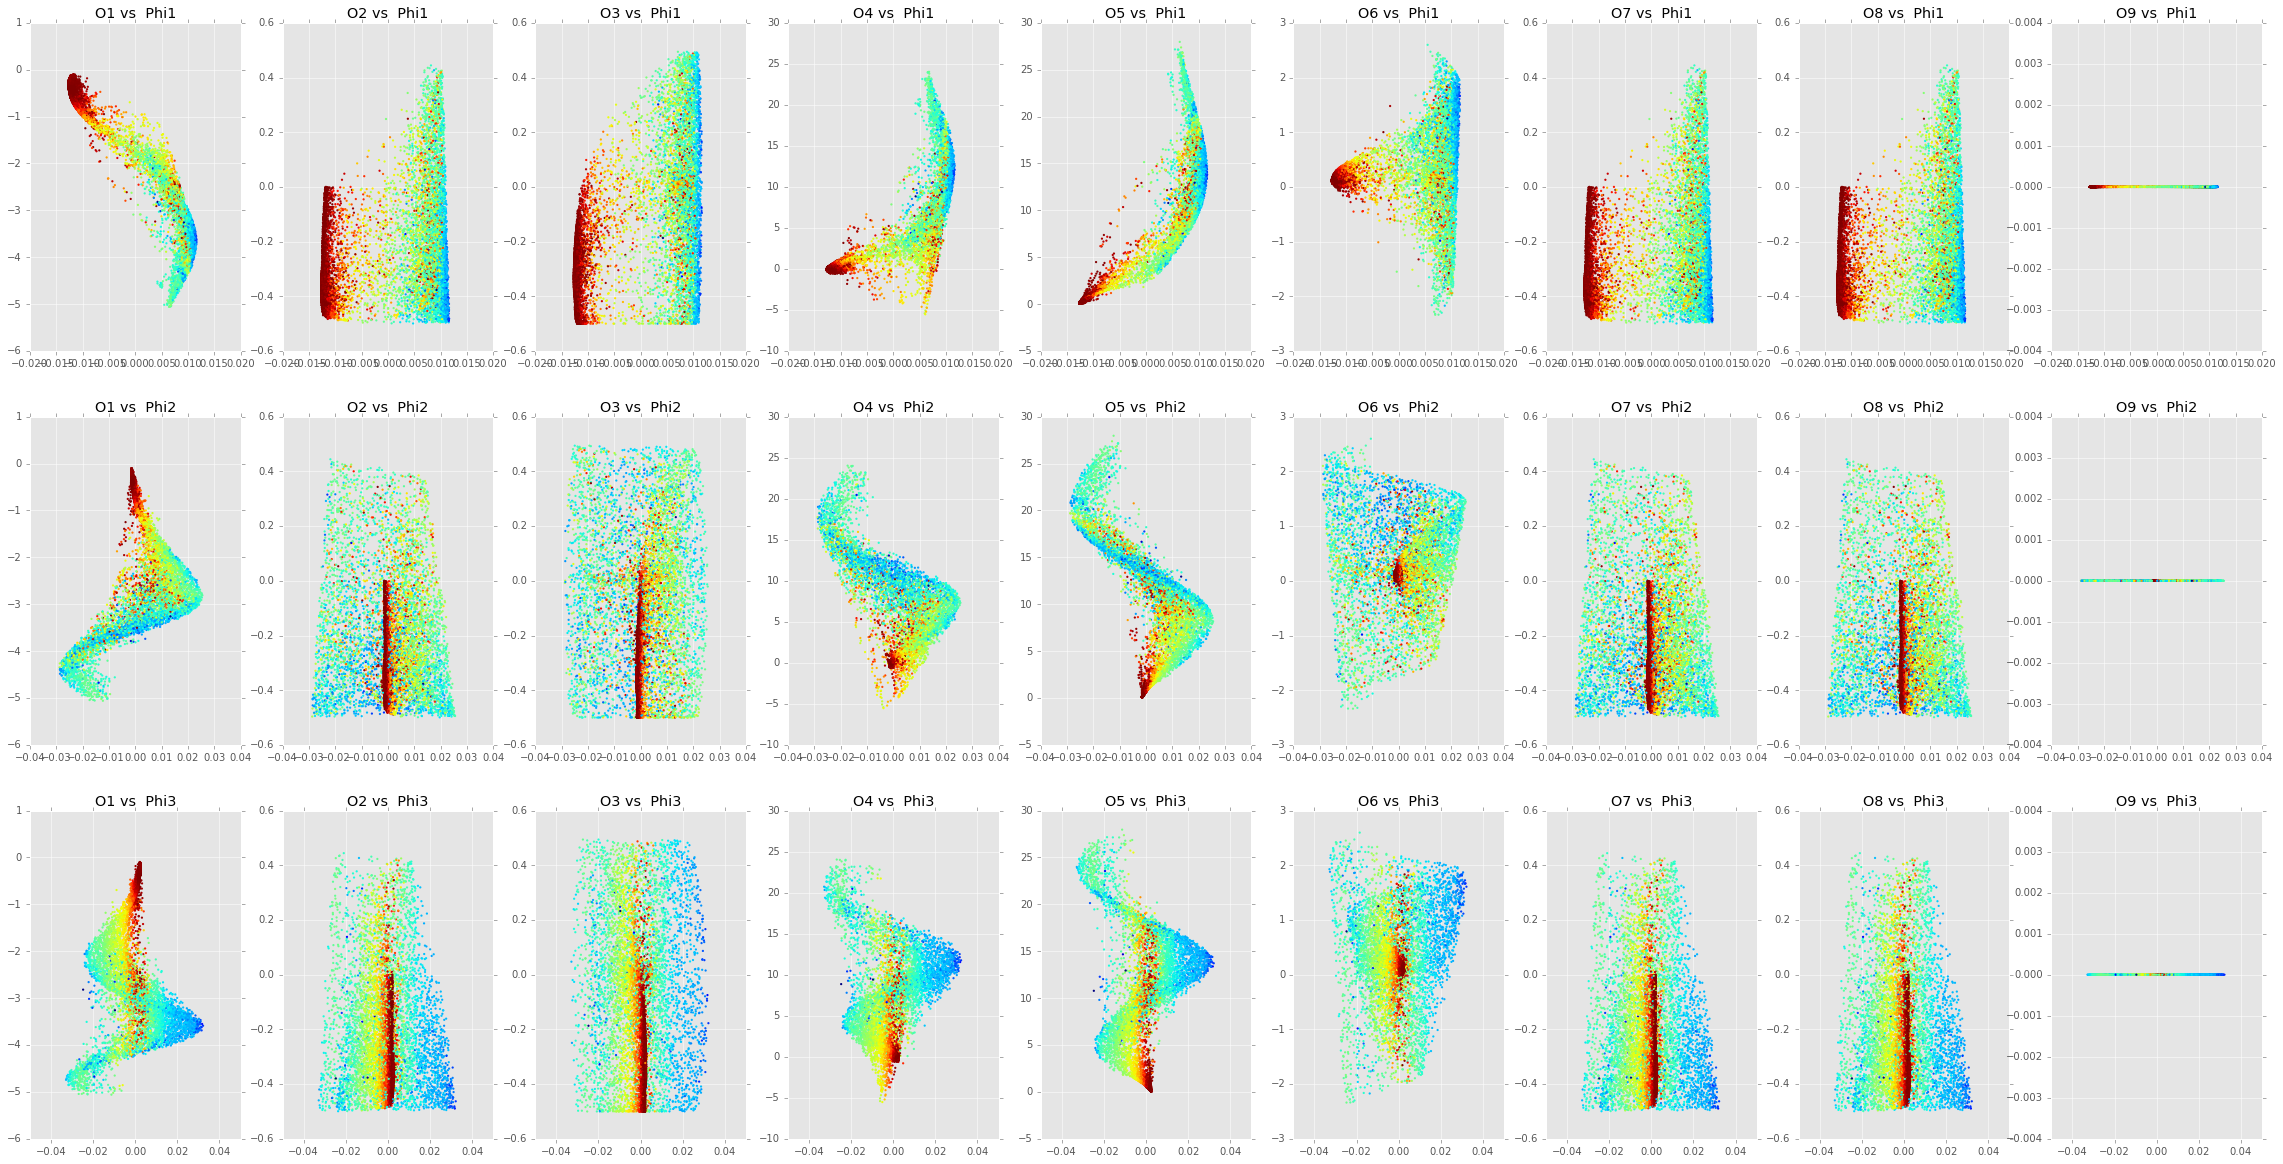

In [118]:
make_scatterplts(X[:,0:X.shape[-1]/2],label_shift = 0)

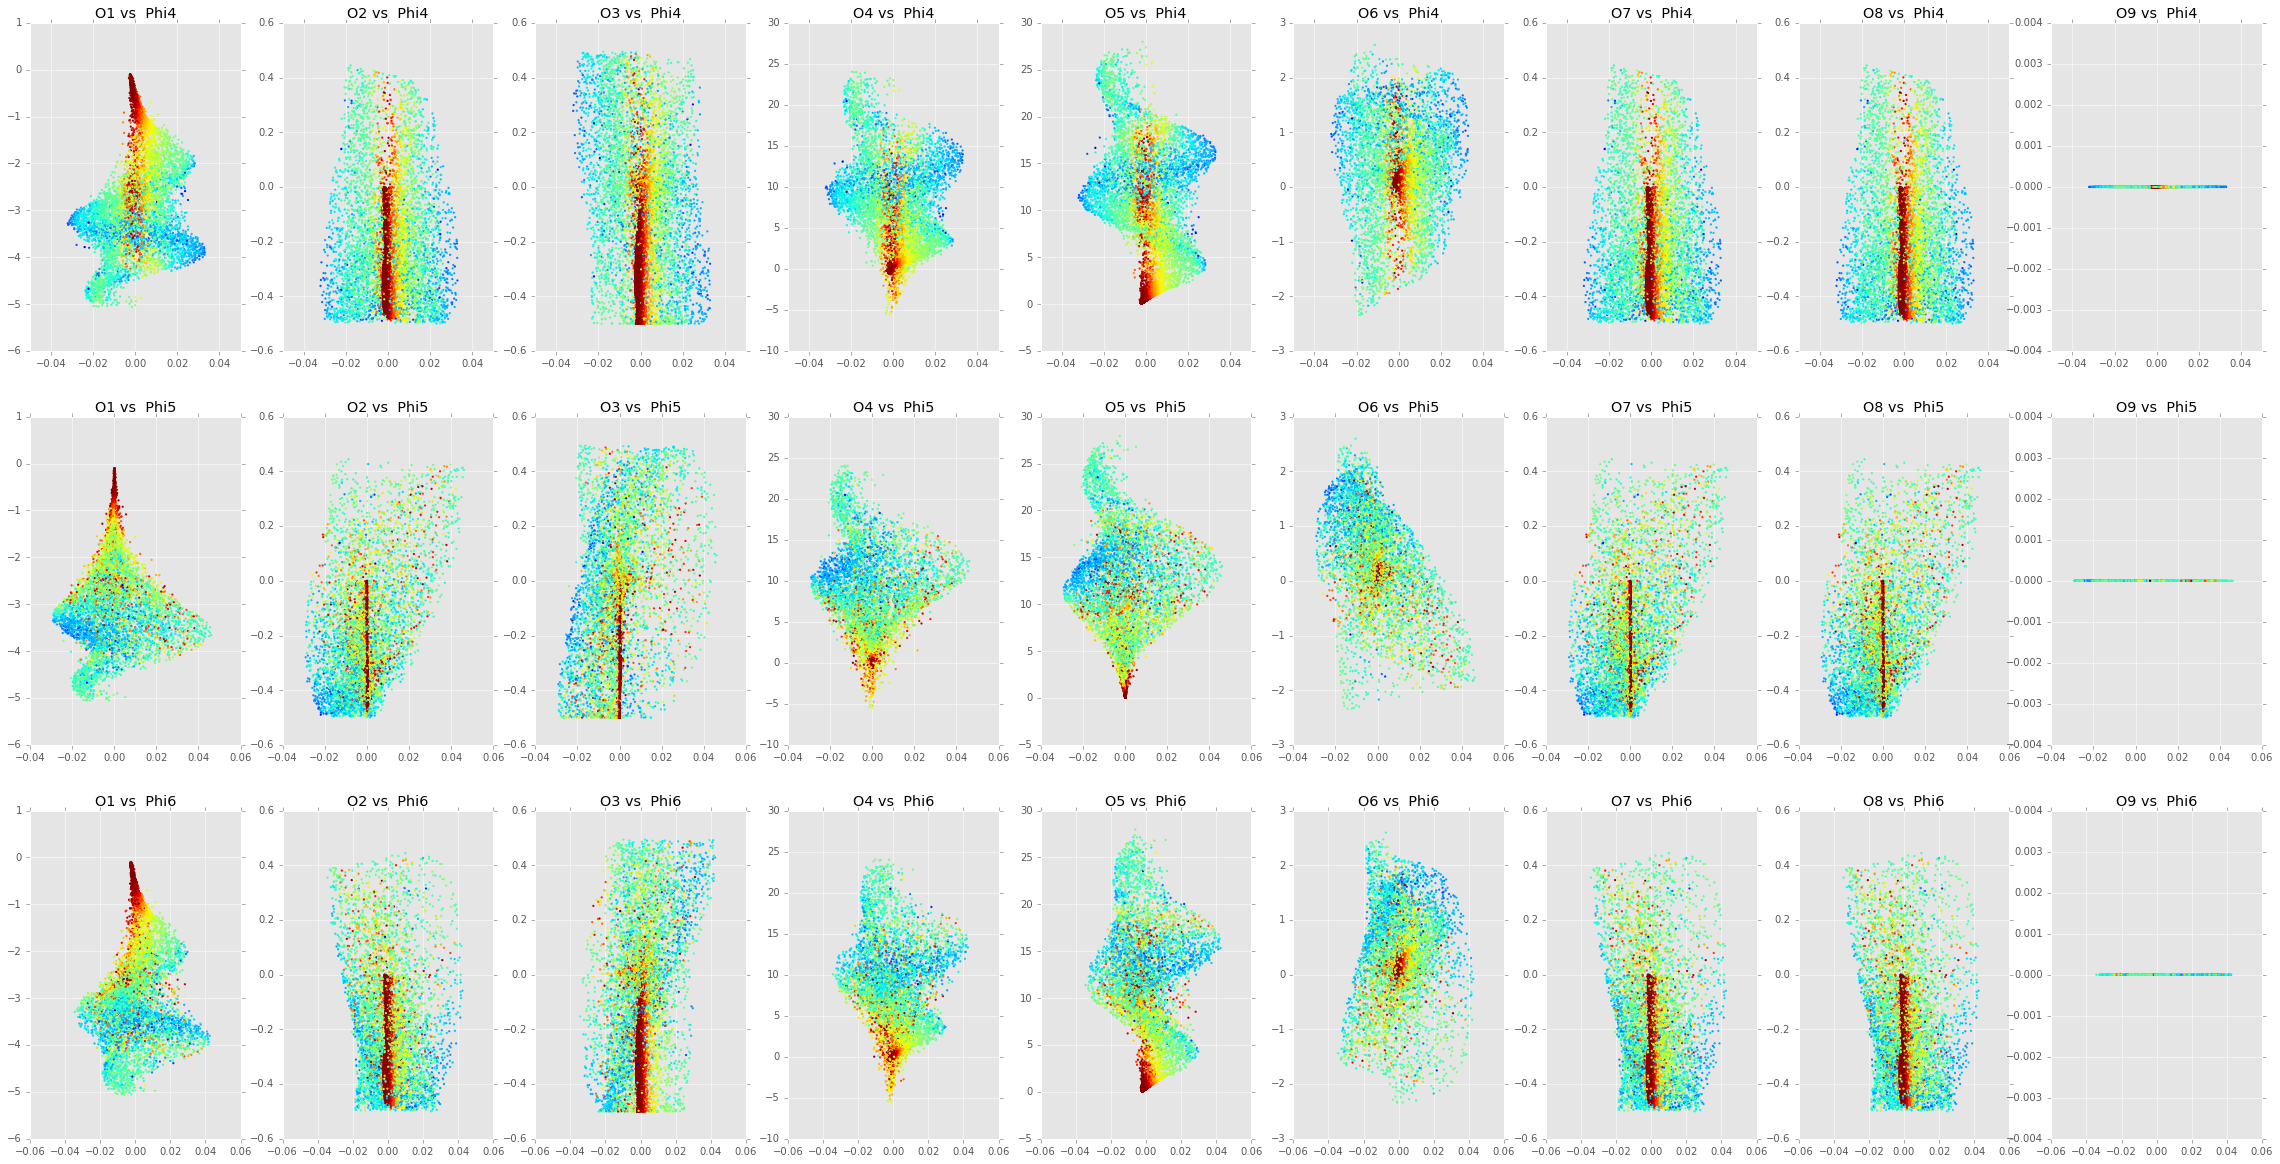

In [119]:
make_scatterplts(X[:,X.shape[-1]/2:],label_shift = X.shape[-1]/2)

#  Next, we explore different ways of building Markov Models. 

## Method 1. Let's make a Markov Model by clustering nearby states.

In [64]:
T_dict_agg = {}

In [72]:
n_clusters = 50
labels = get_cluster_labels(X,n_clusters)
clusters = get_clusters(labels,n_clusters)
T_dict_agg[n_clusters] = make_markov_model(labels,n_clusters)

In [73]:
expects_sampled_0 = np.asarray([traj_expects[0][i] for i in sample_indices])
expects_in_clusters = [np.average([expects_sampled_0[i] for i in clusters[k]]) for k in range(n_clusters) ]
D = {num:i for num,i in  zip(expects_in_clusters,range(n_clusters))}
D_inv = {val:key for key,val in zip(D.keys(),D.values())} ##useful for other things
cluster_order = [D[key] for key in sorted(D.keys())]

def order_indcies(mat):
    return np.asmatrix([[mat[i,j] for i in cluster_order] for j in cluster_order])

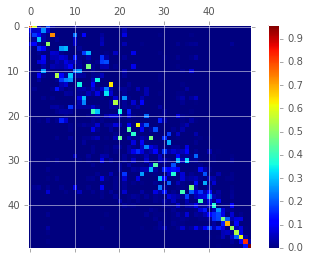

In [74]:
contour_plot(order_indcies(T_dict_agg[n_clusters]))

In [57]:
n_clusters = 2000
labels = get_cluster_labels(X,n_clusters)
clusters = get_clusters(labels,n_clusters)
T_dict_agg[n_clusters] = make_markov_model(labels,n_clusters)

In [908]:
# summarizing_plots(n_clusters,labels,clusters,bins = 100)

In [907]:
# ## Sparsity?

# print np.count_nonzero(T_dict_agg[n_clusters])
# print T_dict_agg[n_clusters].shape

In [906]:
# plt.plot([np.count_nonzero(T_dict_agg[n_clusters][i]) for i in range(n_clusters)])
# plt.title("Number of clusters each clusters can transition to")

#### Comment: many states only transition to a single other state when n_clusters is large. This is a sign there is a lot of overfitting, but at the same time we will see below transition probabilities are more or less preserved.

## Testing Markov Models: How well do the clusters preserve expectation values?

In [905]:
# ## Plot the original dynamics (right) versus the original dynamics inserted into 
# ## each cluster and given the average expectation value in that cluster (left).

# point_in_which_cluster = get_point_in_which_cluster(clusters)
# obs_sample_points = get_obs_sample_points(sample_indices)
# expect_in_clusters = get_expect_in_clusters(clusters,n_clusters, obs_sample_points)
# reduced_model_time_series = get_reduced_model_time_series(expect_in_clusters,sample_indices,point_in_which_cluster)
# plot_original_versus_reduced_timeseries(obs_sample_points, reduced_model_time_series)

## Testing Markov Models: Transition rates in reduced models

In [909]:
# ## Generated dynamics (left) versus original dynamics

# obs_generated = get_obs_generated(T_dict_agg[n_clusters],expect_in_clusters,steps = 10000)
# plot_original_versus_generated_timeseries(obs_generated,obs_sample_points)

In [747]:
which_clusters = [5,10,15,20,25,30,100,1000,2000]
sampled_chunk = 1
n_clusters_with_base_mod = np.array([-1,  5, 10, 15, 20, 25, 30, 40, 50, 60] )  ##locations on graph
n_clusters_with_base = np.asarray([-1] + which_clusters) ## actual locations (except base = -1)

labels_d_g, clusters_d_g, T_d_g, timeseries_g = models_on_fixed_chunk(
                                                          X,
                                                          clusters,
                                                          num_data_points,
                                                          sample_indices,
                                                          which_clusters = which_clusters,
                                                          sampled_chunk = sampled_chunk, 
                                                          training_scheme = 'agg_clustering',
                                                                    )

## transition stats for newly generated trajectories.
trans_stats_dict_g = {}
for n_clusters in which_clusters:
    print "stats for n_clusters" , n_clusters ,"for chunck number", 1
    trans_stats_dict_g[1,n_clusters] = transition_stats(timeseries_g[1,n_clusters],moving_ave =10);
    
## transition stats for base trajectory
trans_stats_dict_g[1,-1] = [i for i in transition_stats(traj_expects[0][sample_indices], num_chunck = 1,moving_ave =10)]

completed n_clusters 5
completed n_clusters 10
completed n_clusters 15
completed n_clusters 20
completed n_clusters 25
completed n_clusters 30
completed n_clusters 100
completed n_clusters 1000
completed n_clusters 2000
stats for n_clusters 5 for chunck number 1
num transitions in each chunck [72, 69, 82, 82, 77, 92, 89, 70, 74, 71, 68, 74, 78, 74, 75, 82, 72, 90, 90, 87]
Expected steps before transition 127.551658163
total transitions 1568
Estimated relative error 0.0216724160454
stats for n_clusters 10 for chunck number 1
num transitions in each chunck [80, 79, 80, 81, 76, 65, 81, 83, 81, 96, 81, 90, 86, 100, 85, 81, 78, 76, 76, 84]
Expected steps before transition 122.026235509
total transitions 1639
Estimated relative error 0.0197605232384
stats for n_clusters 15 for chunck number 1
num transitions in each chunck [84, 77, 76, 88, 84, 86, 71, 92, 89, 68, 88, 76, 67, 67, 78, 75, 72, 94, 71, 83]
Expected steps before transition 126.104035309
total transitions 1586
Estimated relative e

In [748]:
#### Plot transition rates versus n_cluster

# ys = [trans_stats_dict_g[1,i] for i in n_clusters_with_base]
# ys_ave = [np.average(y) for y in ys]
# ys_std = [np.std(y) for y in ys]

# width = 1.       # the width of the bars
# fig, ax = plt.subplots(figsize = (25,10),)

# rects1 = ax.bar(n_clusters_with_base_mod, ys_ave, width, color='#00bfff', yerr=ys_std,
#                error_kw=dict(ecolor='#000080') )

# ax.set_xticks(n_clusters_with_base_mod + width / 2)

# ax.set_xticklabels( ['Original traj'] +[str(c) for c in which_clusters ] , fontdict = { 'size' : 26})
# ax.set_ylabel('Number of transitions', fontdict = { 'size' : 26})
# ax.set_xlabel('Number of clusters used in model', fontdict = { 'size' : 26})
# ax.set_title('Number of transitions in reduced model', fontdict = { 'size' : 26})


# #     plt.bar(n_clusters_with_base,ys_ave);

# plt.show()

## Observations

### Playing with the paramters, it seems the transition probabilities of the input trajecotry is approached as the number of states used for the Markov model becomes large.
### The second two observables (J, J_z) are still not perfectly captured on small timescales
### Of course, there is a lot of overfitting. We need to solve this by either (1) doing the diffusion maps step faster so we can use more data points (in principle $O(n \log n)$, or (2) use Nystrom's approximation to add new points to the data set for which the diffusion map has been found. Using the latter, we could add more points to the diffusion space, making better clusters (more points per cluster) with better transiton probabilities (more ways to transition among clusters).

In [57]:
#### How the clusters look like in diffusion space

# for k in range(1,6):
#     for i in range(1+k,7):
#         plt.figure(figsize= (10,10))
#         plt.scatter(X[:, k - 1], X[:, i - 1], c=labels, cmap=plt.cm.spectral)
#         plt.title("Coordinates: " + str(i) + "versus " + str(k) )

## Method 2. Hidden Markov Models using hmmlearn library

In [78]:
sample_n_clusters = 20

In [79]:
T_dict = {}

In [80]:
np.random.seed(42)

In [81]:
n_clusters = sample_n_clusters
labels, hmm_model = get_hmm_hidden_states(X,n_clusters,return_model=True, n_iter=1000, covariance_type = 'full',)
clusters = get_clusters(labels,n_clusters)
T_dict[n_clusters] = make_markov_model(labels,n_clusters)

/Users/gil/.local/lib/python2.7/site-packages/hmmlearn/base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
/Users/gil/.local/lib/python2.7/site-packages/hmmlearn/base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
/Users/gil/.local/lib/python2.7/site-packages/hmmlearn/base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
/Users/gil/.local/lib/python2.7/site-packages/hmmlearn/base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
/Users/gil/.local/lib/python2.7/site-packages/hmmlearn/base.py:624: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
/Users/gil/.local/lib/python2.7/site-packages/hmmlearn/base.py:451: RuntimeWarning: divide by zero encountered in log
  n_samples, n_components, np.log(self.startprob_),


converged True


/Users/gil/.local/lib/python2.7/site-packages/hmmlearn/base.py:452: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_), framelogprob)


### NOTES:

The covariance structure that seems to work the best is 'full'. 
If n_clusters is too large, n_iter must be increased. Otherwise
it seems the covariance matrix sometimes becomes not symmetric
positive semi-deifinite and this throws an exception.
This seems to be less of a problem when using more sample points
for the diffusion map, presumably because the structure of the 
manifold is better well-defined.

The transition matrices obtained appear to already be sparse.
This is a good thing.

In [82]:
expects_sampled_0 = np.asarray([traj_expects[0][i] for i in sample_indices])
expects_in_clusters = [np.average([expects_sampled_0[i] for i in clusters[k]]) for k in range(n_clusters) ]
D = {num:i for num,i in  zip(expects_in_clusters,range(n_clusters))}
D_inv = {val:key for key,val in zip(D.keys(),D.values())} ##useful for other things
cluster_order = [D[key] for key in sorted(D.keys())]

def order_indcies(mat):
    return np.asmatrix([[mat[i,j] for i in cluster_order] for j in cluster_order])

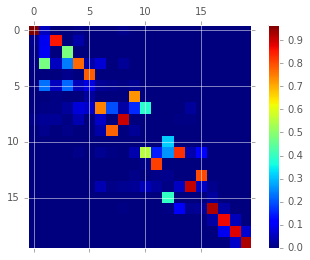

In [83]:
contour_plot(order_indcies(T_dict[n_clusters]))

In [84]:
from matplotlib.patches import Ellipse
from scipy.stats import gaussian_kde

In [145]:
def ellipses_plot(indices):
    # Calculate the point density
    ### from http://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
    x = vecs[:,indices[0]+1]
    y = vecs[:,indices[1]+1]

    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)


    def sorted_eigs(e_vals,e_vecs):
        ## Then sort the eigenvectors and eigenvalues s.t. the eigenvalues monotonically decrease.
        l = zip(e_vals,e_vecs.T)
        l.sort(key = lambda z: -z[0])
        return np.asarray([el[0] for el in l]),np.asarray([el[1] for el in l]).T


    covariances = np.asarray([[[hmm_model.covars_[clus,n,m] 
                                for n in indices] 
                                    for m in indices]
                                        for clus in range(n_clusters)])
    means = np.asarray([[hmm_model.means_[clus,n] 
                                for n in indices] 
                                    for clus in range(n_clusters)])


    sorted_eig_lst = [sorted_eigs(*la.eig(cov)) for cov in covariances]



    angles = np.rad2deg(np.asarray([np.arctan2(*v[1][:,0]) for v in sorted_eig_lst]))
    widths = [2*std_dev*np.sqrt(v[0][0]) for v in sorted_eig_lst]
    heights = [2*std_dev*np.sqrt(v[0][1]) for v in sorted_eig_lst]

    # e = Ellipse(xy=[0,0], width=5, height=2, angle=10)
    es = [Ellipse(xy=mean, width=width, height=height, angle=angle,
                  edgecolor='black', facecolor='none',linewidth = 1)
             for mean,width,height,angle in zip(means,widths,heights,angles) ]


    fig = plt.figure(0,figsize= (14,14) )
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(111, )
    ax.set_title("coordinates "+str(indices[0]+1)  +","+str(indices[1]+1) )

    for e in es:
        ax.add_artist(e)
    #     e.set_alpha(0.5)
        e.set_clip_box(ax.bbox)
        e.set_clip_box(ax.bbox)

    ax.set_xlim(-.04, .04 )
    ax.set_ylim(-.04,.04 )

    # fig, ax = plt.subplots()
    ax.scatter(x, y, c=np.log(z), s=100, edgecolor='')
#     plt.show()


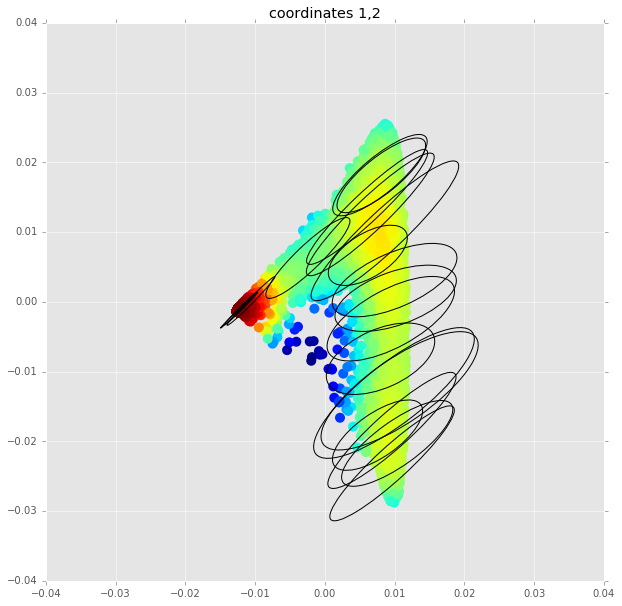

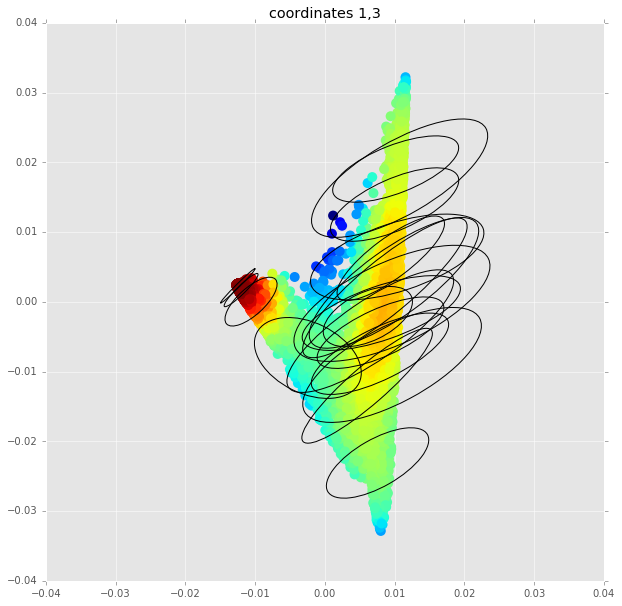

In [148]:
%matplotlib inline
std_dev = 1

# indices = [] ## which indices to get the covariance for

for indices in [[0,1],[0,2]]: ##[0,2],[0,3],[1,2],[1,3],[2,3]
    ellipses_plot(indices)
    plt.show()

In [86]:
# summarizing_plots(n_clusters,labels,clusters)
# T_dict[n_clusters] = make_markov_model(labels,n_clusters)

## Analysis of Markov chains (method 2)

For the analysis below, I assume the cells above have executed for some desirable labels and n_clusters. Later we can put this into functions.

In [782]:
# ### More hidden states induce more sparsity.

# eps_arr = np.arange(0,1,0.05)
# for k in sorted(T_dict.keys()):
#     plt.plot(eps_arr ,map(lambda eps: count_greater_than_eps(T_dict[k], eps) / float(k**2), eps_arr))
#     plt.title("sparsity fraction versus number f hidden states")

## Testing Markov Models: How well do the clusters preserve expectation values?

In [916]:
# ## Plot the original dynamics (right) versus the original dynamics inserted into 
# ## each cluster and given the average expectation value in that cluster (left).

# point_in_which_cluster = get_point_in_which_cluster(clusters)
# obs_sample_points = get_obs_sample_points(sample_indices)
# expect_in_clusters = get_expect_in_clusters(clusters,n_clusters, obs_sample_points)
# reduced_model_time_series = get_reduced_model_time_series(expect_in_clusters,sample_indices,point_in_which_cluster)
# plot_original_versus_reduced_timeseries(obs_sample_points, reduced_model_time_series)

## Number of transitions versus time averaged timeseries

In [910]:
# index = 0

In [911]:
# test_moving_ave = np.arange(10,100,10)
# red_trans = [cluster_observable_series(reduced_model_time_series[index],moving_ave=moving_ave, plot = False)
#                 for moving_ave in test_moving_ave]
# obs_sample_trans = [cluster_observable_series(obs_sample_points[index],moving_ave=moving_ave,plot = False)
#                         for moving_ave in test_moving_ave]

In [912]:
# plt.plot(test_moving_ave,obs_sample_trans)
# plt.plot(test_moving_ave,red_trans)

## Testing Markov Models: Transition rates in reduced models

In [913]:
# ## Generated dynamics (left) versus original dynamics

# obs_generated = get_obs_generated(T_dict[n_clusters],expect_in_clusters,steps = 10000)
# plot_original_versus_generated_timeseries(obs_generated,obs_sample_points)

## Using model generated by hmmlearn

In [914]:
# _ , Z = hmm_model.sample(10000)

# obs_generated_hmm = [[expect_in_clusters[l][cluster] for cluster in Z ] for l in obs_indices]

# f, axarr = plt.subplots(3, 2,figsize=(30,20))
# for l in obs_indices:
#     axarr[l, 0].plot(obs_generated_hmm[l])
#     axarr[l, 1].plot(obs_sample_points[l])
# plt.show()

In [915]:
# transition_stats(traj_expects[0],moving_ave =10);

# Estimate of transition probailities and comparison to method 1

##  next, we do a more thorough analysis, training different cluster sizes on different parts of the original trajectory. We want to see how well the transition times match (and how much overfitting we will find).

In [783]:
which_clusters = [5,10,15,20,25,30]
sampled_chunk = 1
n_clusters_with_base_mod = np.array([-1,  5, 10,15,20,25,30] )  ##locations on graph
n_clusters_with_base = np.asarray([-1] + which_clusters) ## actual locations (except base = -1)

labels_d, clusters_d, T_d, timeseries = models_on_fixed_chunk(
                                                      X,
                                                      clusters,
                                                      steps = num_data_points,
                                                      sample_indices = sample_indices,
                                                      which_clusters = which_clusters,
                                                      sampled_chunk = sampled_chunk, 
                                                      training_scheme = 'hmm',
                                                      covariance_type = 'full',
                                                     )

converged True
completed n_clusters 5
converged True
completed n_clusters 10
converged True
completed n_clusters 15
converged True
completed n_clusters 20
converged True
completed n_clusters 25
converged True
completed n_clusters 30


In [784]:
## transition stats for newly generated trajectories.
trans_stats_dict = {}
for n_clusters in which_clusters:
    print "stats for n_clusters" , n_clusters ,"for chunck number", 1
    trans_stats_dict[1,n_clusters] = transition_stats(timeseries[1,n_clusters],moving_ave =10);
    
## transition stats for base trajectory
trans_stats_dict[1,-1] = [i for i in transition_stats(traj_expects[0][sample_indices], num_chunck = 1,moving_ave =10)]

stats for n_clusters 5 for chunck number 1
num transitions in each chunck [42, 63, 58, 54, 60, 54, 65, 61, 60, 55, 83, 50, 54, 43, 56, 48, 62, 73, 55, 58]
Expected steps before transition 173.311091854
total transitions 1154
Estimated relative error 0.035414281156
stats for n_clusters 10 for chunck number 1
num transitions in each chunck [53, 43, 50, 46, 54, 56, 49, 48, 58, 52, 50, 35, 48, 45, 56, 32, 50, 48, 52, 30]
Expected steps before transition 209.42513089
total transitions 955
Estimated relative error 0.0350394405901
stats for n_clusters 15 for chunck number 1
num transitions in each chunck [35, 48, 48, 29, 51, 49, 41, 42, 39, 39, 33, 57, 41, 36, 50, 48, 53, 52, 44, 44]
Expected steps before transition 227.532423208
total transitions 879
Estimated relative error 0.0365991340018
stats for n_clusters 20 for chunck number 1
num transitions in each chunck [48, 33, 38, 50, 41, 38, 34, 41, 44, 44, 29, 49, 40, 40, 44, 37, 31, 42, 46, 39]
Expected steps before transition 247.525990099
t

In [785]:
comparing_with_method1 = True

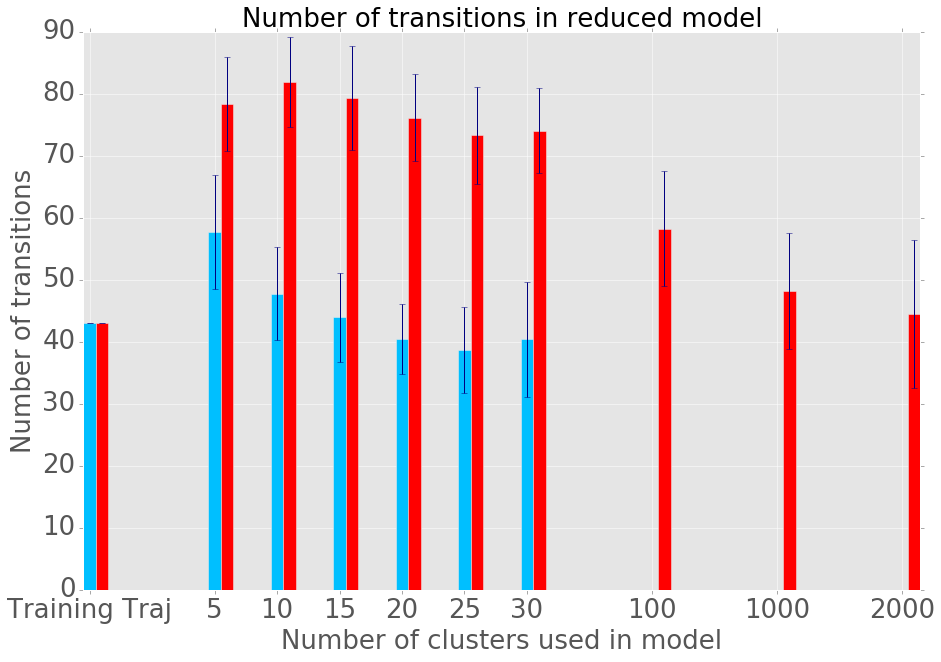

In [786]:
sampled_chunk = 1

# which_clusters = [5,10,15,20,25,30]
n_clusters_with_base_mod = np.array([-5,5, 10,15,20,25,30  ] )  ##locations on graph
n_clusters_with_base  = np.array([-1,5,10,15,20,25,30]) ## locations in dict

n_clusters_with_base = np.asarray([-1] + which_clusters)
ys = [trans_stats_dict[sampled_chunk,i] for i in n_clusters_with_base]
ys_ave = [np.average(y) for y in ys]
ys_std = [np.std(y) for y in ys]

width = 1.       # the width of the bars

fig, ax = plt.subplots(figsize = (15,10),)

rects1 = ax.bar(n_clusters_with_base_mod, ys_ave, width, color='#00bfff', yerr=ys_std,
           error_kw=dict(ecolor='#000080') )

ax.tick_params(axis='both', which='major', labelsize=26)

ax.set_xticks(n_clusters_with_base + width / 2)
ax.set_xticklabels( ['Original traj'] +[str(c) for c in which_clusters ] , fontdict = { 'size' : 26})
ax.set_ylabel('Number of transitions', fontdict = { 'size' : 26})
ax.set_xlabel('Number of clusters used in model', fontdict = { 'size' : 26})
ax.set_title('Number of transitions in reduced model', fontdict = { 'size' : 26})

#####

if comparing_with_method1:
    which_clusters = [5,10,15,20,25,30,100,1000,2000] 
    n_clusters_with_base_mod = np.array([-5,5, 10, 15, 20, 25, 30, 40, 50, 60] ) + width  ##locations on graph.
    n_clusters_with_base  = np.array([-1,5,10,15,20,25,30,100,1000,2000]) ## locations
    ys = [trans_stats_dict_g[1,i] for i in n_clusters_with_base]
    ys_ave = [np.average(y) for y in ys]
    ys_std = [np.std(y) for y in ys]

    rects2 = ax.bar(n_clusters_with_base_mod, ys_ave, width, color='r', yerr=ys_std,
                   error_kw=dict(ecolor='#000080') )
    ax.set_xticks(n_clusters_with_base_mod + width / 2 - 1)
    ax.set_xticklabels( ['Training Traj'] + [str(c) for c in which_clusters ] , fontdict = { 'size' : 26})

plt.show()

### Observations:

Above we plot three observables for the original system, and for the clustered (reduced) system.
We include plots with all the timesteps, as well we timesteps averaged over 10 or 30 steps.

The reduced dynamics maintain the slow-time dynamics of the original system.
For observables 1 and 2 (J and J_z), some of the fast dynamics are not 
fully captured. However, when averaging the system over groups of several
timesteps (giving the slow dynamics) the reduced system and the original 
system appear similar.

## Let's see how well the T matrix generated from the transition between labeled data points compates with the hmm transition matrix

In [787]:
# n_clusters = sample_n_clusters

# contour_plot(T_dict[n_clusters]);
# contour_plot(hmm_model.transmat_);
# contour_plot(T_dict[n_clusters] - hmm_model.transmat_);

We see it varies a little, but not by much. Presumably hmmlearn learns the transition rates differently.

# Below: work in progress

## Another experiment: Trying to learn the action of $H_{eff}$ and $L$ on the clusters

In [788]:
# Regime = "absorptive_bistable"
# location = './make_quantum_jump_trajectories/trajectory_data/'

# pkl_file = open(location + Regime +'.pkl', 'rb')
# pkl_dict = pickle.load(pkl_file)
# pkl_file.close()

# L_times = pkl_dict["col_times"]
# which_L = pkl_dict["col_which"]
# delta_t = pkl_dict['delta_t']

In [789]:
# traj_expects

In [790]:
# L_times

In [791]:
# which_L

In [792]:
# def filter_by_bounds(lst,low,high):
#     return filter(lambda z: low < z < high, lst)

In [793]:
# t_low = 47000
# t_high = 50000

# L_times_for_i = {ind:[] for ind in set(which_L)}
# for t,i in zip(L_times,which_L):
#     L_times_for_i[i].append(t / delta_t)
    
# L_times_in_zone = filter_by_bounds(L_times_for_i[1],t_low,t_high)
# gauss_filtered_L_times = np.asarray([sum([np.exp(-(t - t_in_zone)**2/400) 
#                                             for t_in_zone in L_times_in_zone])
#                                                  for t in range(t_low,t_high)])


# plt.figure(figsize=(20,10))
# plt.plot(-traj_expects[0][t_low:t_high])
# plt.scatter(np.asarray(L_times_in_zone) - t_low,[0 for _ in range(len(L_times_in_zone))])

# plt.xlim((0,t_high-t_low))
# plt.plot(gauss_filtered_L_times )

In [794]:
# t_low = min(sample_indices)
# t_high = max(sample_indices)

In [795]:
# num_jumps_per_cluster = {c:0 for c in range(n_clusters)}
# for jump_time in filter_by_bounds(L_times_for_i[1],t_low,t_high):
#     jump_int = int(jump_time) - t_low
#     num_jumps_per_cluster[labels[jump_int]] +=1

In [796]:
# num_in_cluster = {c: len(clusters[c]) for c in range(n_clusters)}

In [797]:
# plt.plot(num_jumps_per_cluster.keys(), num_jumps_per_cluster.values())
# plt.title("number of jumps per cluster over sample trajectory");
# plt.show()

# plt.plot( num_jumps_per_cluster.keys(), [float(num_jumps) / cluster_total  for num_jumps, cluster_total in zip(num_jumps_per_cluster.values(),num_in_cluster.values())])
# plt.title("Normalized jump probability from each cluster");
# plt.show()

In [798]:
# def filter_by_jumps(indices,jump_times):
#     '''
#     Generate a dictionary mapping each possible number of jumps
#     taken in a single timestep 
#     '''
#     num_jumps_dict = {}
#     jump_index = 0
#     time_index = 0
    
#     while time_index < len(indices):
#         num_jumps = 0
#         while jump_times[jump_index] < time_index + 1:
#             num_jumps += 1
#             jump_index += 1
#         if not num_jumps in num_jumps_dict:
#             num_jumps_dict[num_jumps] = []
#         else:
#             num_jumps_dict[num_jumps].append(time_index)
#         time_index += 1
#     return num_jumps_dict

In [799]:
# all_jump_times = set()
# for jump_times in L_times_for_i.values():
#     all_jump_times = all_jump_times.union(set(jump_times))
# all_jump_times = sorted(list(all_jump_times))

In [800]:
# num_jumps_dict = filter_by_jumps(sample_indices,all_jump_times)

In [801]:
# len(num_jumps_dict[0])

In [802]:
# label_pairs = {}

In [803]:
# for k in num_jumps_dict.keys():
#     label_pairs[k] = [(labels[i],labels[i+1]) for i in num_jumps_dict[k][:-1]]

In [804]:
# def make_markov_model_disjoint_traj(label_pairs,n_clusters):
#     T = np.zeros((n_clusters,n_clusters))
#     for i,j in label_pairs:
#         T[i,j] += 1
#     row_norm = np.squeeze(np.asarray(T.sum(axis = 1)))
#     row_norm = np.power(row_norm,-1)
#     row_norm = np.nan_to_num(row_norm)
#     return (T.T*row_norm).T

In [805]:
# T_with_k_jumps = {}

# for k in num_jumps_dict.keys():
#     T_with_k_jumps[k] = make_markov_model_disjoint_traj(label_pairs[k],n_clusters)

In [807]:
# contour_plot(T_dict[n_clusters]);

In [808]:
# contour_plot(T_with_k_jumps[0] - (T_dict[n_clusters]));
# contour_plot(T_with_k_jumps[1] - (T_dict[n_clusters]));

In [809]:
# for k in num_jumps_dict.keys():
#     contour_plot(T_with_k_jumps[k]);
#     plt.show()

In [810]:
# contour_plot(T_with_k_jumps[0] - T_with_k_jumps[1]);

In [811]:
# E = np.asmatrix(T_with_k_jumps[0])
# E_tilde = np.asmatrix(T_with_k_jumps[1] )

In [812]:
# E_inv = la.inv(E)

In [813]:
# from scipy.linalg import fractional_matrix_power

In [814]:
# contour_plot(E_inv*E_tilde);
# plt.show()

# contour_plot(E_tilde*E_inv);
# plt.show()

# contour_plot(fractional_matrix_power(E_inv,0.5)*E_tilde * fractional_matrix_power(E_inv,0.5));
# plt.show()

In [815]:
# L_hyp = E_tilde*E_inv

In [816]:
# contour_plot(L_hyp.H*L_hyp)

In [817]:
# contour_plot(T_with_k_jumps[0] + T_with_k_jumps[0].T);
# contour_plot(T_with_k_jumps[0] - T_with_k_jumps[0].T);

In [818]:
# G = (np.eye(n_clusters) - T_with_k_jumps[0].T) / delta_t

In [819]:
# la.eig(G)[0]

In [820]:
# G_H = (G - G.T) / 2j

In [821]:
# G_LL = (G + G.T)

In [822]:
# lamd,eig_V  = la.eig(G_LL)

In [823]:
# lamd

In [824]:
# contour_plot(G_H);
# contour_plot(G_LL);

In [825]:
# G_L = la.cholesky(G_LL - 1.01*min(lamd)* np.eye(n_clusters))
# contour_plot(G_L)

### Notes:

Above, we assume the transition matrix $P$ equates to $\exp(-iH_\text{eff} t) \approx I - i H_\text{eff}  t$, where $t$ is the legnth of a timestep. With this approximation, we can solves for $H_\text{eff}$, which we can use to solve for $H$ and $\sum_i L_i^\dagger L_i$, since these are the Hermitian and anti-Hermitian components. In the example above, we had to shift the spectrum slightly get get a positive definite matrix for $L^\dagger L$. This would be expected when many of the eigenvalues are small.  Other ways to fix this are discussed in "Correcting Non Positive Definite Correlation Matrices" by Stef Maree.

Note the self Hamiltonian $H$ will have zero on its diagonal. This means the model doesn't have self-energy terms. 

The $H$ term captures the oscillatory behavior in the Markov chain, much like it would in a natural open quantum system model, while the $L$ controls exponential decay towards the steady state, much like the collapse operator would during coherent evolution.

The $L$ operator is still undertermined to a factor of a unitary, since Cholesky gives the unique $L$ that has positive entries on the diagonal. We need a way to find it

In [826]:
# G_H_ord = np.asmatrix([[G_H[i,j] for i in cluster_order] for j in cluster_order])

In [827]:
# contour_plot(G_H_ord)

In [828]:
# G_LL_ord = np.asmatrix([[G_LL[i,j] for i in cluster_order] for j in cluster_order])

In [829]:
# contour_plot(G_LL_ord)

In [830]:
# G_L_ord = la.cholesky(G_LL_ord - 1.00001*min(lamd)* np.eye(n_clusters)).H
# contour_plot(G_L_ord)

In [831]:
# P_ord = np.asmatrix([[T_with_k_jumps[0][i,j] for i in cluster_order] for j in cluster_order])

In [832]:
# contour_plot(P_ord)

In [833]:
# la.eig(G)[1][4]

In [834]:
# import scipy.sparse.linalg as sla

In [835]:
# P_vals, P_vecs = la.eig(P_ord)

In [836]:
# vals_ascending = sorted(zip(P_vals,P_vecs.T), key = lambda z: abs(z[0]))

In [838]:
##### eigenvalue

# vals_ascending[-1][0]

In [839]:
# evec = vals_ascending[-1][1]
# u = (evec/evec.sum()).real 

In [840]:
# u ## steady state

In [841]:
# (P_ord*u.T).T ## confirm u is steady state

In [842]:
# hmm_model.means_[0]

In [843]:
# map_to = np.asarray([points[i] for i in clusters[0]])

In [844]:
# map_from = np.asarray([X[i] for i in clusters[0]])

In [845]:
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression
# from sklearn.pipeline import Pipeline

In [846]:
# num_points_in_cluster = len(map_from)
# num_points_sampled_in_cluster = 100
# num_points_tested_in_cluster = 100

In [847]:
# which_indices_to_sample = np.random.choice(
#                         num_points_in_cluster,
#                         num_points_sampled_in_cluster + num_points_tested_in_cluster)

In [848]:
# def get_at_indices(lst,indices):
#     return np.asarray([lst[i] for i in indices])

In [849]:
# map_from_sample = get_at_indices(map_from,which_indices_to_sample[0:num_points_sampled_in_cluster])
# map_to_sample = get_at_indices(map_to,which_indices_to_sample[0:num_points_sampled_in_cluster])

# map_from_test = get_at_indices(map_from,which_indices_to_sample[num_points_sampled_in_cluster:])
# map_to_test = get_at_indices(map_to,which_indices_to_sample[num_points_sampled_in_cluster:])

In [850]:
# model = Pipeline([('poly', PolynomialFeatures(degree=2)),
#                     ('linear', LinearRegression(fit_intercept=False)),
#                  ])
# model = model.fit(map_from_sample,map_to_sample)
# model.named_steps['linear'].coef_

In [851]:
# model.score(map_from_test,map_to_test)

In [852]:
# pkl_dict["H_num"]

## Preparation for Nystrom

In [853]:
# tree = tree_container(points.tolist(),"FS_metric")


In [854]:
# D_nys = {tuple(value):i for i,value in enumerate(points)}

In [855]:
# def Nystrom(target_point,tree,D,num_neighbors,X,diffusion_epsilon = 0.5):
#     neighbors = tree.find_N_neighbors(target_point.tolist(),num_neighbors,'FS_metric')
#     if num_neighbors == 1:
#         return X[D_nys[tuple(neighbors[0])]]
#     neighbor_IDs = [D_nys[tuple(n)] for n in neighbors]
#     neighbor_diff_coords = np.asarray([X[ID] for ID in neighbor_IDs])
#     distances = np.asarray([FS_metric(target_point,np.asarray(n)) for n in neighbors])
#     Ks = np.exp(-distances**2 / (2. * diffusion_epsilon) )
#     return np.dot(Ks,neighbor_diff_coords) / len(neighbors)

In [856]:
# ## Examples

# print Nystrom(target_point,tree,D_nys,1,X)
# print Nystrom(target_point,tree,D_nys,2,X)
# print Nystrom(target_point,tree,D_nys,20,X)

In [857]:
# Ls = pkl_dict["L_num"]

In [858]:
# X_inv = {tuple(val):i for i,val in enumerate(X)}

In [859]:
# X_inv[tuple(X[4])]

In [860]:
# point_in_clus = {}
# for c_i,c in enumerate(clusters):
#     for p in c:
#         point_in_clus[p] = c_i

In [861]:
# ###  TODO: Use a better prediction algorithm for which cluster


# def make_L_confusion_and_action_matrices(which_L):
    
#     L_origin = np.asmatrix(np.zeros((10,10)))
#     L_final = np.asmatrix(np.zeros((10,10)))
#     L_p_norms = np.zeros(10)
    

#     for cluster_index in range(n_clusters):
#         num_to_sample = min(200,len(clusters[cluster_index]))
#         points_in_cluster_index = range(num_to_sample)

#         predicted_for_true_lst = []
#     #     predicted_for_interpolated_lst = []
#         predicted_for_Lp_lst = []
#         Lp_norm_lst = []

#         for point_in_cluster_index in points_in_cluster_index:
#             point_index = clusters[cluster_index][point_in_cluster_index]
#             p_doubled_real = np.asmatrix(points[point_index])
#             p = (p_doubled_real[:,:100] + 1j * p_doubled_real[:,100:]).T
#             Lp = np.asarray((which_L * p).T)[0]
#             Lp_norm = la.norm(Lp)
#             Lp_norm_lst.append(Lp_norm)
#             Lp /= Lp_norm
#             print Lp
#             Lp_arr = np.concatenate((Lp.real,Lp.imag))

#             ## True diffusion coordinate

# #             psi_diff_coord_true = X[point_index]
# #             predicted_for_true_lst.append(hmm_model.predict([psi_diff_coord_true]*20)[-1])

#             predicted_for_true_lst.append(point_in_clus[point_index])

#             ## Interpolated diffusion coordinate of |psi>

#     #         psi_diff_coord = Nystrom(np.asarray(p_doubled_real)[0], tree,D_nys, 20, X)
#     #         predicted_for_interpolated_lst.append(hmm_model.predict([psi_diff_coord]*20)[-1])

#             ## Interpolated diffusion coordinate of L |psi>

#             L_psi_diff_coord = Nystrom(Lp_arr, tree,D_nys, 1, X)
#             predicted_for_Lp_lst.append( point_in_clus[X_inv[tuple(L_psi_diff_coord)]]  )
            
# #             predicted_for_Lp_lst.append(hmm_model.predict([L_psi_diff_coord]*20)[-1])

#         for el in predicted_for_true_lst:
#             L_origin[cluster_index,el] += 1./num_to_sample
#         for el in predicted_for_Lp_lst:
#             L_final[cluster_index,el] += 1./num_to_sample
#         for Lp_norm in Lp_norm_lst:
#             L_p_norms[cluster_index] += Lp_norm**2 / num_to_sample

#     return L_origin,L_final,L_p_norms

In [2441]:
# L_origin,L_final,L_p_norms = make_L_confusion_and_action_matrices(np.asmatrix(np.eye(100)))#(Ls[0])

# contour_plot(order_indcies(L_origin))
# contour_plot(order_indcies(L_final))

In [862]:
# L_origin_0,L_final_0,L_p_norms_0 = make_L_confusion_and_action_matrices(Ls[0])

# contour_plot(order_indcies(L_origin_0))
# contour_plot(order_indcies(L_final_0))
# # contour_plot(order_indcies(L_final_0)*order_indcies(L_final_0).H)
# # contour_plot(order_indcies(L_final_0).H*order_indcies(L_final_0))

In [863]:
# plt.plot(np.asarray([L_p_norms_0[i] for i in cluster_order]))
# plt.title('')

In [864]:
# L_origin_1,L_final_1,L_p_norms_1 = make_L_confusion_and_action_matrices(Ls[1])

# contour_plot(order_indcies(L_origin_1))
# contour_plot(order_indcies(L_final_1))
# # contour_plot(order_indcies(L_final_1)*order_indcies(L_final_1).H)
# # contour_plot(order_indcies(L_final_1.H)*order_indcies(L_final_1))

In [865]:
# plt.plot(np.asarray([L_p_norms_1[i] for i in cluster_order]))

##  Notes

The biggest difference we see is in row/column 3. 
This is the cluster that had few samples (38), so in practice we might want to give it
less weight or throw it out altogether.

In [866]:
# from scipy.optimize import minimize

In [867]:
# def error(x):
#     c1,c2 = x
#     return la.norm  ((order_indcies(c1* L_final_1.H)*order_indcies(L_final_1)
#             +c2*order_indcies(L_final_0.H)*order_indcies(L_final_0))
#           - G_LL_ord* delta_t ) 

In [868]:
# res =  minimize(error, [1.,1.], method='BFGS', options={'disp': True})

In [869]:
# res.x

In [870]:
# error(res.x)

In [871]:
# error([0.5,0.])

In [872]:
# (c1,c2) = res.x

In [873]:
# contour_plot(G_LL_ord* delta_t)

In [874]:
# contour_plot((c1* order_indcies(L_final_1.H)*order_indcies(L_final_1)
#             +c2*order_indcies(L_final_0.H)*order_indcies(L_final_0)))

In [875]:
# contour_plot((0.5* order_indcies(L_final_1.H)*order_indcies(L_final_1)
#             +0.*order_indcies(L_final_0.H)*order_indcies(L_final_0)))

In [876]:
# contour_plot(order_indcies(L_final_1))
# contour_plot(G_L_ord)

In [877]:
# from scipy.linalg import expm

In [878]:
# def unitary_matrix(arr, matrix_size = 10):
#     if len(arr) != matrix_size**2:
#         raise ValueError('wrong number of parameters')
#     diag = arr[:matrix_size]
#     off_diag_r = arr[matrix_size:matrix_size*(matrix_size+1)/2]
#     off_diag_m = arr[matrix_size*(matrix_size+1)/2:]
#     U = np.zeros((matrix_size,matrix_size),dtype=complex)
#     for i in range(matrix_size):
#         U[i,i] = diag[i]
#     el = 0
#     for i in range(matrix_size):
#         for j in range(i+1,matrix_size):
#             U[i,j] = off_diag_r[el] + 1j * off_diag_m[el]
#             U[j,i] = np.conj(U[i,j])
#             el += 1
#     return np.asmatrix(expm(1j*U))

In [879]:
# def unit_error(arr,L_org,L_target,arr2 = None,matrix_size = 10):
#     if arr2 is None:
#         return la.norm( abs( unitary_matrix(arr,matrix_size)*L_org) - abs(L_target) )
#     elif len(arr2) != matrix_size:
#         raise ValueError("arr2 has wrong size")
#     else:
#         return la.norm( abs( unitary_matrix(arr,matrix_size)*L_org)
#                             - np.asmatrix(np.asarray(abs(L_target)) * np.asarray(arr2) ) )

In [880]:
# mat_error = lambda x: unit_error(x,G_L_ord*np.sqrt(delta_t),order_indcies(L_final_1)*np.sqrt(c1))

In [881]:
# mat_error_with_norm = lambda x: unit_error(x[:100],
#                                            G_L_ord*np.sqrt(delta_t),
#                                            order_indcies(L_final_1)*np.sqrt(c1),
#                                            arr2 = x[100:])

In [882]:
# res =  minimize(mat_error, np.random.rand(100), method='BFGS', options={'disp': True})

In [883]:
# res2 =  minimize(mat_error_with_norm,
#                  np.concatenate( (np.random.rand(100), np.asarray([1.]*10) )) ,
#                         method='BFGS', options={'disp': True})

In [884]:
# res2.x[100:]

In [885]:
# G_L_new = unitary_matrix(res.x)*G_L_ord*np.sqrt(delta_t)

In [886]:
# G_L_new_2 = unitary_matrix(res2.x[:100])*G_L_ord*np.sqrt(delta_t)

In [887]:
# contour_plot(G_L_ord*np.sqrt(delta_t))

In [888]:
# contour_plot(G_L_new)

In [889]:
# contour_plot(G_L_new_2)

In [890]:
# contour_plot(order_indcies(L_final_1)*np.sqrt(c1))

In [892]:
### Norm between original (Cholesky) L matrix and empirical L transition matrix

# la.norm(abs(G_L_ord*np.sqrt(delta_t)) - abs(order_indcies(L_final_1)*np.sqrt(c1)))

In [895]:
### norm between new L and transitions from empirical L without scale freedom

# la.norm(abs(G_L_new) - abs(order_indcies(L_final_1)*np.sqrt(0.5)))

In [896]:
# ## norm between new L and transitions from empirical L with scale freedom.

# contour_plot((abs(G_L_new_2) - np.asmatrix(np.asarray(abs(order_indcies(L_final_1)*np.sqrt(c1))) * res2.x[100:])))
# la.norm(abs(G_L_new_2) - np.asmatrix(np.asarray(abs(order_indcies(L_final_1)*np.sqrt(c1))) * res2.x[100:]))

In [897]:
#### error between rotated L and empirical L (no scale freedom).
# contour_plot((abs(G_L_new) - (abs(order_indcies(L_final_1)*np.sqrt(c1))) ))

In [898]:
# contour_plot(G_L_new_2)

In [899]:
# contour_plot(np.asarray(abs(G_L_new_2)) / sum(np.asarray(abs(G_L_new_2))) ) 

In [900]:
# contour_plot(np.asarray(abs(order_indcies(L_final_1) )) / sum(np.asarray(abs(order_indcies(L_final_1) ))) )

In [901]:
# contour_plot(abs(order_indcies(L_final_1)*np.sqrt(c1)))

In [902]:
# contour_plot(( np.asmatrix(np.asarray(abs(order_indcies(L_final_1)*np.sqrt(c1))) * res2.x[100:])))

In [903]:
# L_tests = [np.asmatrix(np.asarray(abs(order_indcies(L_final_1)*np.sqrt(c1))) * res2.x[100:]) / np.sqrt(delta_t),
#            G_L_new / np.sqrt(delta_t),
#            G_L_new_2 / np.sqrt(delta_t),
#           ]

In [904]:
# pkl_file = open('testing_reduced_models' + Regime +'.pkl', 'wb')
# pickle.dump((G_H_ord,L_tests,sorted(expects_in_clusters),delta_t),pkl_file)
# pkl_file.close()

### How orthogonal are clusters?

In [256]:
c = {}
for k in range(10):
    c[k] = np.asarray([points[i] for i in clusters[k]])

In [268]:
FS_matrix =np.zeros((10,10))

In [298]:
for j in range(10):
    for l in range(10):
        FS_matrix[j,l] =  np.average( 
                                np.average([ 
                                    [FS_metric(c[j][i],c[l][k]) 
                                        for i in range(38) 
                                            for k in range(38)]
                            ]))

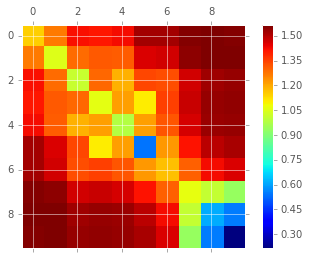

In [1387]:
contour_plot(order_indcies(FS_matrix))

## Notes

One thing I tried was taking the operator evolving the Markov chain when no jumps are present and setting it equal to $H_\text{eff}  = H - \frac{i}{2} L^\dagger L$ to solve for an effective form of $H$ and $L$. However, the $L^\dagger L$ cannot be factorized since it isn't positive definite. In reflection, it makes sense we can't do this because the Markov dynamics are purely real, whereas the $H_\text{eff}$ term as both real and complex evolution terms.

Another thing I tried was orthonormalizing the Markov states to obtain a proper basis. However, this was hard because it requires sending the mean value of a cluster in diffusion space to a true quantum state (the basis element to participate in the orthonormalization). However, the mapping in the opposite direction (i.e. state space to diffusion space) is many to one, so it is not possible to find a good quantum state like this.

###     Run Markov chain for probability of being in each state.

In [593]:
def run_markov_chain_average(init_state, T, steps = 1000):
    '''
    Run Markov chain for probability of being in each state.
    '''
    
    ## check for s
    if T.shape[0] != init_state.shape[1] or T.shape[1] != init_state.shape[1]:
        raise ValueError("wrong dimensions in T and init_state.")
    
    current = init_state
    outs = []
    for i in range(steps):
        outs.append(current)
        current = current * T
    return np.asarray(outs)

In [1644]:
init_ss = [] 
steps_ave_photon_num_lst = []

for i in range(n_clusters):
    
    init_state = np.matrix([[0.] for _ in range(n_clusters)]).T
    init_state[0,i] = 1.
    init_ss.append(init_state)

    steps = run_markov_chain_average(init_state,T_dict[n_clusters])
    steps_ave_photon_num_lst.append([np.average([abs(D_inv[i]*s_val) for i,s_val in enumerate(s[0])]) for s in steps] )

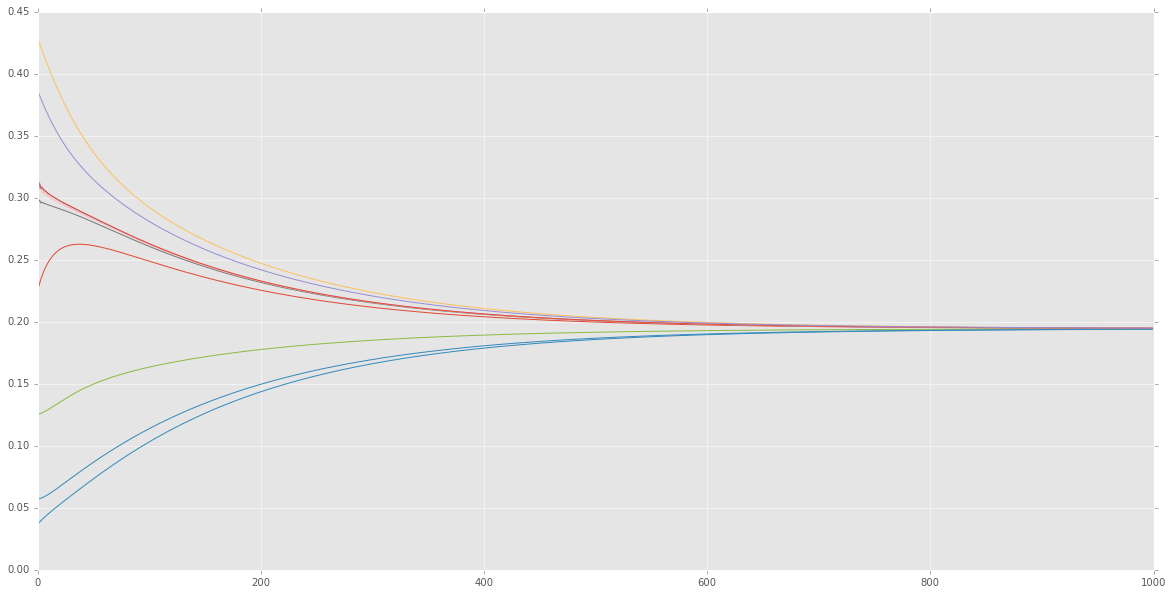

In [1645]:
plt.figure(figsize=(20,10))
for el in steps_ave_photon_num_lst:
    plt.plot(el)

## What to do next

Look over Nystrom again.

We wish to find not only a Markov model, but also a mode detailed model that specifies 

For each L, count the number of times L was applied for each cluster over all timesteps, and what the result was. Learn the transition rate between clusters (using MLE) for each number of times L has been applied. For zero times, we are learning the transition rates of $H_{eff}$ alone. We also can learn the probability each number of times $L$ has been applied for each cluster over a given time. This should agree with the estimate for a jump $\delta t = \left< \psi \right| L^\dagger L \left| \psi \right>$.

Another way of estimating the $L \psi$ is using some kind of quadrature on $L \psi_i$ for each $\psi_i$ in a given cluster. Then we know the action of $L$ on each cluster.

If we orthogonalize the cluster states (e.g. Shmidt), then we can obtain a proper quantum model, where each cluster state gives a basis. In this case, the jump probabilities could be computed directly, once we learn $L$ in the reduced space. 

### Some other things to try

Instead of a usual Markov chain, we can consider what happens if the transition rates are also functions of the previous state and the length of time spent in a given state. Such a model could be written as another Markov model.

Try using Kalman filter instead of HMM.

Normalize by diffusion coordinates, better numerical properties?